In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

import warnings
warnings.filterwarnings("ignore")

In [2]:
random = {
    'dataset': ['bank', 'gym', 'heart', 'titanic'],
    'brier_adj': [0.18111966687301606, 0.17634326427209, 0.09262259701874374, 0.15942538000177728 ],
    'baseline_brier': [0.1835232471728478, 0.2018081787955161, 0.0982194936261805, 0.178996854771902],
    'best_params': [{'lambda_l1': np.float64(0.0010799951355893044),
 'lambda_l2': np.float64(0.0023431799179763242),
 'learning_rate': np.float64(0.020747900173109644),
 'max_depth': 4,
 'min_data_in_leaf': 44,
 'n_estimators': 826,
 'num_leaves': 95}, {'lambda_l1': np.float64(0.00922459366331435),
 'lambda_l2': np.float64(1.399010917215618),
 'learning_rate': np.float64(0.06927911541220201),
 'max_depth': 3,
 'min_data_in_leaf': 107,
 'n_estimators': 204,
 'num_leaves': 113}, {'lambda_l1': np.float64(0.024046589187280348),
 'lambda_l2': np.float64(1.435018335977515),
 'learning_rate': np.float64(0.02848552988592319),
 'max_depth': 3,
 'min_data_in_leaf': 63,
 'n_estimators': 335,
 'num_leaves': 19}, {'lambda_l1': np.float64(1.3783040076490758),
 'lambda_l2': np.float64(0.002278843910062451),
 'learning_rate': np.float64(0.2665593954919876),
 'max_depth': 9,
 'min_data_in_leaf': 15,
 'n_estimators': 976,
 'num_leaves': 110}]
}

In [3]:
bayes = {
    'dataset': ['bank', 'gym', 'heart', 'titanic'],
    'brier_adj': [0.18122801197098, 0.17641367844845726, 0.09400881135862903, 0.15707694668742653 ],
    'baseline_brier': [0.1835232471728478, 0.2018081787955161, 0.0982194936261805, 0.178996854771902],
    'best_params': [{'num_leaves': 48,
 'max_depth': 3,
 'learning_rate': 0.05435540423360091,
 'n_estimators': 530,
 'min_data_in_leaf': 17,
 'lambda_l1': 0.002952940475566768,
 'lambda_l2': 0.008827094934083417}, {'num_leaves': 121,
 'max_depth': 11,
 'learning_rate': 0.015085930199236954,
 'n_estimators': 1238,
 'min_data_in_leaf': 195,
 'lambda_l1': 0.6454514615582414,
 'lambda_l2': 4.947618936915183}, {'num_leaves': 111,
 'max_depth': 3,
 'learning_rate': 0.1393294953681854,
 'n_estimators': 184,
 'min_data_in_leaf': 14,
 'lambda_l1': 3.8202799180166545,
 'lambda_l2': 0.020159194967265724}, {'num_leaves': 71,
 'max_depth': 9,
 'learning_rate': 0.021733200861349226,
 'n_estimators': 190,
 'min_data_in_leaf': 20,
 'lambda_l1': 0.6498966498082488,
 'lambda_l2': 0.19982074000815617}] 
}



In [4]:
subsets = {
    'frac': [0.25, 0.50, 0.75, 1.00],
    'brier_cv': [0.195943, 0.184016, 0.181311, 0.181857],
    'brier_test': [0.199599, 0.190480, 0.188018, 0.181228],
    'best_params': [
        {'num_leaves': 41,
 'max_depth': 3,
 'learning_rate': 0.06634535820075341,
 'n_estimators': 286,
 'min_data_in_leaf': 47,
 'lambda_l1': 0.13695227494564602,
 'lambda_l2': 9.977382596095024},
        {'num_leaves': 93,
 'max_depth': 3,
 'learning_rate': 0.10846684240269427,
 'n_estimators': 184,
 'min_data_in_leaf': 17,
 'lambda_l1': 0.2739006821035618,
 'lambda_l2': 6.73800098234884},
        {'num_leaves': 64,
 'max_depth': 3,
 'learning_rate': 0.060104947349619416,
 'n_estimators': 369,
 'min_data_in_leaf': 28,
 'lambda_l1': 0.8904689770478909,
 'lambda_l2': 1.544358693177717},
        {'num_leaves': 48,
 'max_depth': 3,
 'learning_rate': 0.05435540423360091,
 'n_estimators': 530,
 'min_data_in_leaf': 17,
 'lambda_l1': 0.002952940475566768,
 'lambda_l2': 0.008827094934083417}
    ]
}

### Approach for establishing best hyperparameter set for LightGBM:
1. Choose better brier score out of two hyperparameter tuning methods for each dataset
2. Calculate median of hyperparameter values among chosen using criterium above

In [5]:
bayes_df = pd.DataFrame(bayes)
random_df = pd.DataFrame(random)
subsets_df = pd.DataFrame(subsets)

In [6]:
subsets_df

,frac,brier_cv,brier_test,best_params
0,0.25,0.195943,0.199599,"{'num_leaves': 41, 'max_depth': 3, 'learning_r..."
1,0.50,0.184016,0.190480,"{'num_leaves': 93, 'max_depth': 3, 'learning_r..."
2,0.75,0.181311,0.188018,"{'num_leaves': 64, 'max_depth': 3, 'learning_r..."
3,1.00,0.181857,0.181228,"{'num_leaves': 48, 'max_depth': 3, 'learning_r..."


In [7]:
bayes_df.columns

Index(['dataset', 'brier_adj', 'baseline_brier', 'best_params'], dtype='object')

In [8]:
best_params = np.where(
    bayes_df['brier_adj'] < random_df['brier_adj'],
    bayes_df['best_params'],
    random_df['best_params']
)

In [9]:
best_params

array([{'lambda_l1': np.float64(0.0010799951355893044), 'lambda_l2': np.float64(0.0023431799179763242), 'learning_rate': np.float64(0.020747900173109644), 'max_depth': 4, 'min_data_in_leaf': 44, 'n_estimators': 826, 'num_leaves': 95},
       {'lambda_l1': np.float64(0.00922459366331435), 'lambda_l2': np.float64(1.399010917215618), 'learning_rate': np.float64(0.06927911541220201), 'max_depth': 3, 'min_data_in_leaf': 107, 'n_estimators': 204, 'num_leaves': 113},
       {'lambda_l1': np.float64(0.024046589187280348), 'lambda_l2': np.float64(1.435018335977515), 'learning_rate': np.float64(0.02848552988592319), 'max_depth': 3, 'min_data_in_leaf': 63, 'n_estimators': 335, 'num_leaves': 19},
       {'num_leaves': 71, 'max_depth': 9, 'learning_rate': 0.021733200861349226, 'n_estimators': 190, 'min_data_in_leaf': 20, 'lambda_l1': 0.6498966498082488, 'lambda_l2': 0.19982074000815617}],
      dtype=object)

In [10]:
best_params_list = list(best_params)

In [11]:
median_params = pd.DataFrame(best_params_list).median(numeric_only=True).to_dict()

In [12]:
int_params = ['max_depth', 'min_data_in_leaf', 'n_estimators', 'num_leaves', 'min_child_samples']

for param in int_params:
    if param in median_params:
        median_params[param] = int(round(median_params[param]))

print(median_params)

{'lambda_l1': 0.016635591425297348, 'lambda_l2': 0.7994158286118871, 'learning_rate': 0.025109365373636207, 'max_depth': 4, 'min_data_in_leaf': 54, 'n_estimators': 270, 'num_leaves': 83}


#### Preparing data to check result of analysis

In [13]:
X1 = pd.read_csv("preprocessed_datasets/bank_data.csv")
y1 = pd.read_csv("preprocessed_datasets/bank_target.csv")
X2 = pd.read_csv("preprocessed_datasets/gym_data.csv")
y2 = pd.read_csv("preprocessed_datasets/gym_target.csv")
X3 = pd.read_csv("preprocessed_datasets/heartDisease_data.csv")
y3 = pd.read_csv("preprocessed_datasets/heartDisease_target.csv")
X4 = pd.read_csv("preprocessed_datasets/titanic_data.csv")
y4 = pd.read_csv("preprocessed_datasets/titanic_target.csv")

In [14]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)

#### Training model on new hyperparameters and comparing with default set

In [15]:
datasets = [(X1_train, X1_test, y1_train, y1_test),
            (X2_train, X2_test, y2_train, y2_test),
            (X3_train, X3_test, y3_train, y3_test),
            (X4_train, X4_test, y4_train, y4_test)]

In [16]:
results = []
RANDOM_STATE = 42
for i, (X_train, X_test, y_train, y_test) in enumerate(datasets, start=1):
    baseline_model = LGBMClassifier(random_state=RANDOM_STATE)
    baseline_model.fit(X_train, y_train)
    y_prob_baseline = baseline_model.predict_proba(X_test)[:, 1] 
    baseline_brier = brier_score_loss(y_test, y_prob_baseline)

    model = LGBMClassifier(**median_params, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    y_prob_new = model.predict_proba(X_test)[:, 1]
    new_brier = brier_score_loss(y_test, y_prob_new)
    
    results.append({
        'dataset': f'X{i}',
        'baseline_brier': baseline_brier,
        'new_brier': new_brier,
        'improvement': baseline_brier - new_brier 
    })

results_df = pd.DataFrame(results)
print(results_df)

  File "c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
            

[LightGBM] [Info] Number of positive: 4231, number of negative: 4698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 8929, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473849 -> initscore=-0.104699
[LightGBM] [Info] Start training from score -0.104699
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] lambda_l1 is set=0.016635591425297348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016635591425297348
[LightGBM] [Warning] lambda_l2 is set=0.7994158286118871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7994158286118871
[LightGBM] [Warning] min_data_in_leaf is set=54, min_

#### There is improvement in 3 out of 4 datasets, and the deterioration in the first dataset is very small compared to the gains in the other datasets.

In [17]:
print(results_df)

  dataset  baseline_brier  new_brier  improvement
0      X1        0.183523   0.185415    -0.001891
1      X2        0.201808   0.179202     0.022607
2      X3        0.098219   0.093054     0.005166
3      X4        0.178997   0.157195     0.021802


Mean difference: 0.011921
Median difference: 0.013484
Std of difference: 0.012223
Percentage of configurations better than baseline by > 0.001: 75.0%


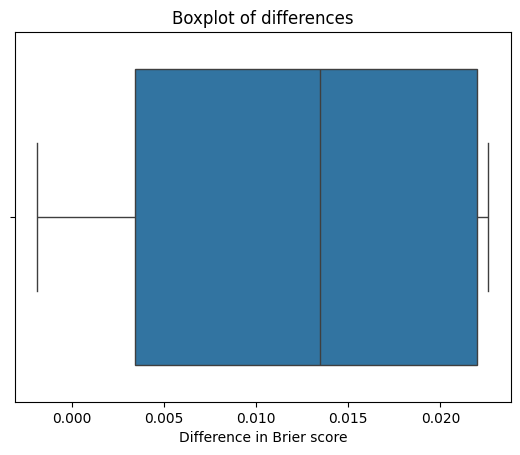

In [18]:
diff = results_df['improvement']

mean_diff = diff.mean()
median_diff = diff.median()
std_diff = diff.std()
epsilon = 0.001 
pct_better = (diff > epsilon).mean() * 100

print(f"Mean difference: {mean_diff:.6f}")
print(f"Median difference: {median_diff:.6f}")
print(f"Std of difference: {std_diff:.6f}")
print(f"Percentage of configurations better than baseline by > {epsilon}: {pct_better:.1f}%")

sns.boxplot(x=diff)
plt.title("Boxplot of differences")
plt.xlabel("Difference in Brier score")
plt.show()

### Analysis of distributions of brier score based on tuning on different dataset sizes

In [19]:
fractions = subsets_df["frac"]
brier_test = subsets_df["brier_test"]

In [20]:
ref_brier = subsets_df.loc[subsets_df['frac']==1.0, 'brier_test'].values[0]
subsets_df['delta_brier'] = subsets_df['brier_test'] - ref_brier
print(subsets_df[['frac', 'delta_brier']])

   frac  delta_brier
0  0.25     0.018371
1  0.50     0.009252
2  0.75     0.006790
3  1.00     0.000000


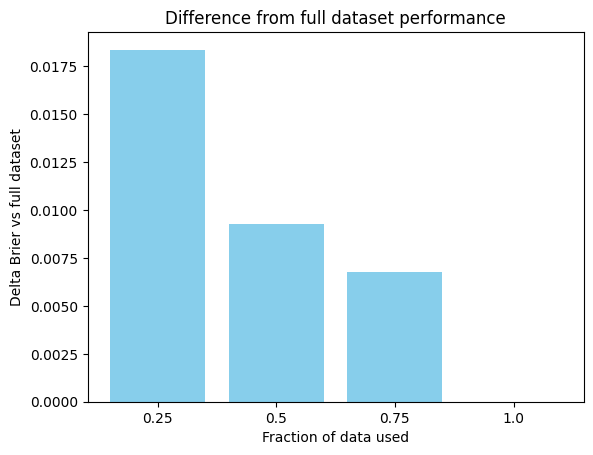

In [21]:
x_labels = subsets_df['frac'].astype(str)

plt.bar(x_labels, subsets_df['delta_brier'], color='skyblue')
plt.xlabel('Fraction of data used')
plt.ylabel('Delta Brier vs full dataset')
plt.title('Difference from full dataset performance')
plt.show()

The greatest difference is observed between 25% and 50% of the data. The smallest improvement in Brier score occurs between 50% and 75%, although there is still a gain when using the full dataset instead of 75%

### Comparison of sampling methods - is there biased sampling?

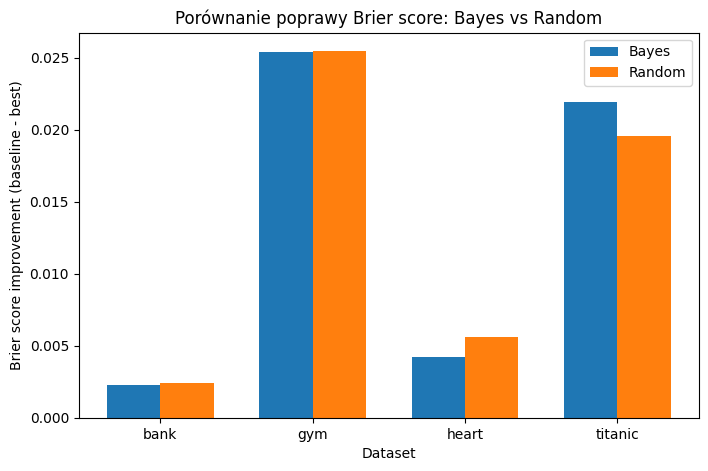

In [24]:
bayes_df['improvement'] = bayes_df['baseline_brier'] - bayes_df['brier_adj']
random_df['improvement'] = random_df['baseline_brier'] - random_df['brier_adj']

plot_df = pd.DataFrame({
    'dataset': bayes_df['dataset'],
    'Bayes': bayes_df['improvement'],
    'Random': random_df['improvement']
})

x = np.arange(len(plot_df['dataset'])) 
width = 0.35 

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width/2, plot_df['Bayes'], width, label='Bayes')
ax.bar(x + width/2, plot_df['Random'], width, label='Random')

ax.set_xlabel('Dataset')
ax.set_ylabel('Brier score improvement (baseline - best)')
ax.set_title('Porównanie poprawy Brier score: Bayes vs Random')
ax.set_xticks(x)
ax.set_xticklabels(plot_df['dataset'])
ax.legend()
plt.show()

##### Statistical test to indicate whether there is significant difference between those groups
For all 12 observations - 4 datasets and 3 algorithms make this test: TODO (Janek dodaj wektory brier)

Wilcoxon test:

H0: no difference between methods

H1: there is significant difference between methods

In [ ]:
brier_random_svc = [0.1893, 0.1676, 0.1085, 0.1645]

bayes_brier_svc = [0.187609, 0.139217, 0.133284, 0.122124]

brier_random_gbm = random_df["brier_adj"]

bayes_brier_gbm = bayes_df["brier_adj"]

bayes_brier_rf = [0.1845966828222708, 0.178241845238274, 0.1066380630627618, 0.1509247744268588]

random_brier_rf = [0.1847155960056662, 0.1769953375792064, 0.1076035974331696, 0.149755908553256]

In [ ]:
all_random = brier_random_gbm + brier_random_svc + random_brier_rf
all_bayes = bayes_brier_gbm + bayes_brier_svc + bayes_brier_rf

In [ ]:
stat, p_value = wilcoxon(all_random, all_bayes, method = "exact")
print(f"Wilcoxon statistic: {stat:.4f}, p-value: {p_value:.4f}")

In [ ]:
diff = all_random - all_bayes
print("Średnia różnica (Random - Bayes):", np.mean(diff))